In [3]:
import seaborn as sns
sns.set_style(rc={'font.family': ['sans-serif'],'axis.labelsize': 24})
sns.set_context("notebook")

# Clustering the P-Pdot diagram

In this work I will follow on from the [previous post](/2015/04/24/Gaussian-mixture-model-for-pulsar-population/)  and extend the work to cluster the pulsars in the P-Pdot diagram using a [Dirichlet Process GMM](http://scikit-learn.org/stable/modules/mixture.html#dpgmm). We will work from the same data set as before.

## The data

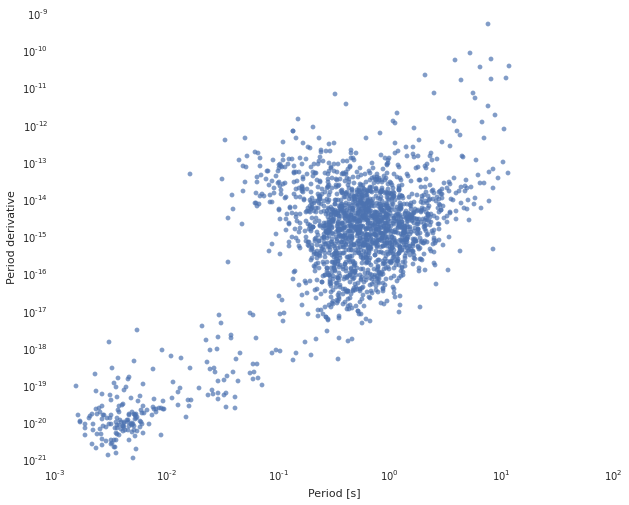

In [24]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
%matplotlib inline

DATA_FILE = "ATNF_data_file.txt"

data = np.genfromtxt(DATA_FILE, skip_header=4, skip_footer=1, dtype=None)
F0 = np.genfromtxt(data[:, 1])
F1 = np.genfromtxt(data[:, 2])

df = pd.DataFrame(dict(F0=F0, F1=F1))
df = df[np.isfinite(df.F0) & np.isfinite(df.F1) & (df.F1 < 0)] # Complete Cases
df['P0'] = 1/df.F0
df['P1'] = -df.F1/df.F0**2

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(df.P0.values, df.P1.values, "o", markersize=4.8, alpha=0.7)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Period [s]")
ax.set_ylabel("Period derivative")

plt.show()


## Clustering

Following on from [this example](http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html) we will cluster the data then plot the confidence ellipsoids for the two populations.

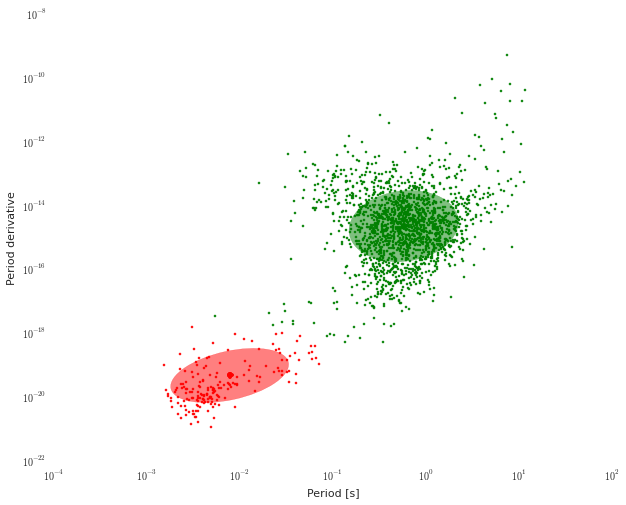

In [23]:
from sklearn.mixture import GMM, DPGMM
from scipy import linalg
import itertools
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

data = np.array([np.log10(df.P0.values),
                 np.log10(df.P1.values)]).T

color_iter = itertools.cycle(['r', 'g', 'b', 'c', 'm'])

fig, ax = plt.subplots(figsize=(10, 8))

model = DPGMM(2, covariance_type='full')
model.fit(data)
prediction = model.predict(data)

for i, (mean, covar, color) in enumerate(zip(
            model.means_, model._get_covars(), color_iter)):
        
        v, w = linalg.eigh(covar)
        u = w[0] / linalg.norm(w[0])
        
        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi  # convert to degrees
    
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ell.set_zorder(100)
        ax.add_artist(ell)
        ax.plot(mean[0], mean[1], "o", color=color)
        
        ax.scatter(data[prediction == i, 0], data[prediction == i, 1], 4.8, color=color)
        
    
ax.set_xlabel("Period [s]")
ax.set_ylabel("Period derivative")


majorFormatter = FormatStrFormatter('$10^{%d}$')
ax.xaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_major_formatter(majorFormatter)

plt.show()

This provides a nice distinction between the two populations